## Desafío 3 - DH - ML Clasificación

<a id="tabla_contenidos"></a> 
### Tabla de Contenidos

#### <a href='#section_proposito'>0. Propósito de esta Notebook</a>
- ##### <a href='#section_motivacion'>0.1 Motivación</a>
- ##### <a href='#section_dataset_info'>0.2 Detalles del Dataset</a>
- ##### <a href='#section_antecedentes'>0.3 Estado del Arte</a>

#### <a href='#section_preparacion'>1. Estudio del Dataset</a>
- ##### <a href='#section_importacion'>1.1 Importación</a>
- ##### <a href='#section_analisis'>1.2 Análisis Exploratorio</a>
- ##### <a href='#section_split'>1.3 Selección de Target</a>

#### <a href='#section_algoritmos'>2. Algoritmos y predicción</a>
- ##### <a href='#acon_dataset'>2.1 Acondicionamiento del Dataset</a>
- ##### <a href='#knn'>2.2 K Nearest Neighbors (KNN)</a>
- ##### <a href='#reg_log'>2.3 Regresión Logística</a>
- ##### <a href='#resultados'>2.4 Comparación de Resultados</a>

#### <a href='#section_consolidacion'>3. Consolidación</a>
- ##### <a href='#pipe'>3.1 Pipelines</a>
- ##### <a href='#conclusion'>3.2 Conclusión</a>

<hr>

### <a id='section_proposito'>0. Propósito de esta Notebook</a>

#### <a id="section_motivacion">0.1 Motivación</a> 

<hr>

<a id='section_preparacion'></a> 
### 1. Preparación del Dataset

### <a id="section_importacion">1.1 Importación de datos</a> 

#### Importación de datos de población y resultados de encuesta
Los datos de población nos permitirán realizar una exploración geográfica de la ubicación de los encuestados

In [1]:
# librerías
import numpy as np
import pandas as pd
import unicodedata

In [2]:
resultados_del_test = pd.read_csv("data/resultados-del-test.csv", delimiter = ",")

In [3]:
poblacion_por_barrio = pd.read_csv("data/caba_pob_barrios_2010.csv")

#### Unifico en un dataset
Elimino tildes en los nombres de los barrios de cada dataset y agrego población por barrio al resultado de las encuestas

In [4]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [5]:
poblacion_por_barrio.BARRIO = poblacion_por_barrio.BARRIO.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [6]:
resultados_del_test.barrio = resultados_del_test.barrio.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [7]:
poblacion_por_barrio.columns = ['barrio', 'poblacion']

In [8]:
poblacion_por_barrio = poblacion_por_barrio.set_index('barrio')

In [9]:
def obtener_poblacion_por_barrio(barrio):
    return poblacion_por_barrio.loc[barrio].poblacion

In [10]:
def imputar_barrio(barrio):
    barrios = poblacion_por_barrio.index.tolist()
    if barrio == "La boca": return "Boca"
    if barrio == "Montserrat": return "Monserrat"
    if barrio == "Villa general mitre": return "Villa gral. mitre"
    if barrio == "La paternal": return "Paternal"
    if barrio == "Otro": return np.random.choice(barrios)
    return barrio

In [11]:
resultados_del_test["barrio_completo"] = resultados_del_test.barrio.apply(imputar_barrio)

In [12]:
resultados_del_test["poblacion_por_barrio"] = resultados_del_test.barrio_completo.apply(obtener_poblacion_por_barrio)

#### Exporto y resguardo el dataset unificado

In [13]:
resultados_del_test.to_csv("data/dataset_joined.csv")

### <a id="section_analisis">1.2 Análisis Exploratorio</a> 

Importo el dataset unificado

In [14]:
dataset = pd.read_csv("data/dataset_joined.csv", delimiter = ",",  index_col = "Unnamed: 0")
dataset.head(3)

,fecha,hora,edad,genero,barrio,pregunta_1,pregunta_2,pregunta_3,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,pregunta_11,pregunta_12,pregunta_13,barrio_completo,poblacion_por_barrio
0,2019-06-14,09:09:00,27,Mujer,Constitucion,A,A,A,B,A,B,C,C,B,C,B,C,C,Constitucion,44107
1,2019-06-13,23:20:00,17,Mujer,Otro,A,B,B,B,B,C,C,B,B,C,B,C,C,Parque avellaneda,53229
2,2019-06-13,16:33:00,15,Mujer,Recoleta,B,B,C,B,C,B,B,A,A,A,A,A,A,Recoleta,157932


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5676 entries, 0 to 5675
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fecha                 5676 non-null   object
 1   hora                  5676 non-null   object
 2   edad                  5676 non-null   int64 
 3   genero                5676 non-null   object
 4   barrio                5676 non-null   object
 5   pregunta_1            5676 non-null   object
 6   pregunta_2            5676 non-null   object
 7   pregunta_3            5676 non-null   object
 8   pregunta_4            5676 non-null   object
 9   pregunta_5            5676 non-null   object
 10  pregunta_6            5676 non-null   object
 11  pregunta_7            5676 non-null   object
 12  pregunta_8            5676 non-null   object
 13  pregunta_9            5676 non-null   object
 14  pregunta_10           5676 non-null   object
 15  pregunta_11           5676 non-null   

#### Visualizamos los nulos

In [16]:
### librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
dataset_columnas = dataset[["fecha",'edad', 'genero', 'barrio','barrio_completo','poblacion_por_barrio']]

In [18]:
from IPython.display import Markdown, display

nulls_by_column = dataset_columnas.isnull().sum()
dataset_size = dataset.shape[0]

for column in nulls_by_column.index:
    column_nulls = nulls_by_column[column]
    null_percentage = 100 * column_nulls / dataset_size
    display(Markdown(f"* ```{column}``` tiene {column_nulls} nulos, lo cual representa el {null_percentage:.2f}%"))

* ```fecha``` tiene 0 nulos, lo cual representa el 0.00%

* ```edad``` tiene 0 nulos, lo cual representa el 0.00%

* ```genero``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio_completo``` tiene 0 nulos, lo cual representa el 0.00%

* ```poblacion_por_barrio``` tiene 0 nulos, lo cual representa el 0.00%

#### Barrio de los encuestados

In [19]:
barrio = dataset.barrio.value_counts().head(5)

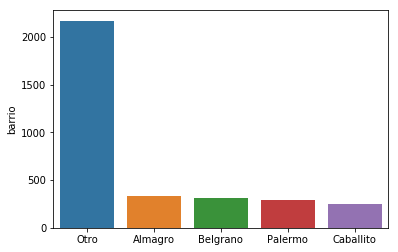

In [20]:
sns.barplot(x=barrio.index, y=barrio)

Vemos los primeros quince barrios con más encuestados

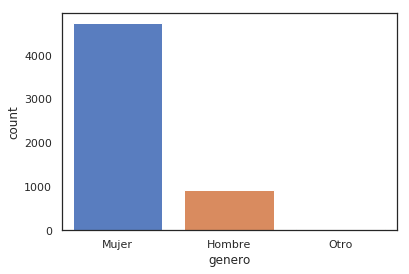

In [136]:
sns.countplot(x='genero', data=dataset)

#### Ploteamos cantidad de participantes de encuesta por barrio

In [22]:
porbarrio = dataset.barrio_completo.value_counts()
#porbarrio = barioss.rename_axis('BARRIO').reset_index(name='counts')
porbarrio.head(5)

Almagro      379
Belgrano     348
Palermo      329
Caballito    301
Agronomia    275
Name: barrio_completo, dtype: int64

In [23]:
porbarrio = porbarrio.to_frame().reset_index()

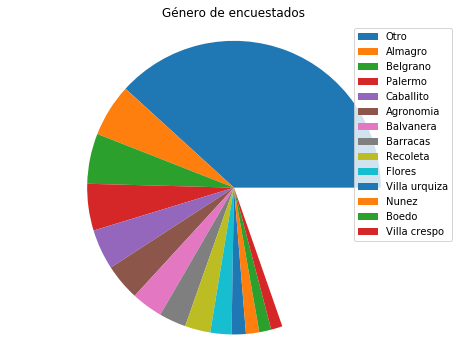

In [24]:
labels = dataset.barrio.value_counts(normalize=True).index[:14]
sizes = list(dataset.barrio.value_counts(normalize=True)[:14])

figura, axis = plt.subplots(figsize=(8,6))
axis.pie(sizes)
axis.axis('equal') 
axis.set_title('Género de encuestados')
axis.legend(labels)

#### Visualizamos las edades

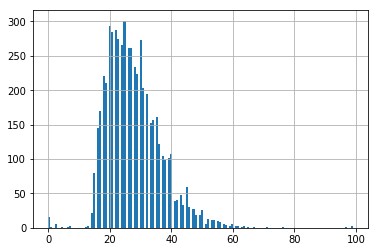

In [25]:
dataset.edad.hist(bins=150);

#####  Visualizamos outliers

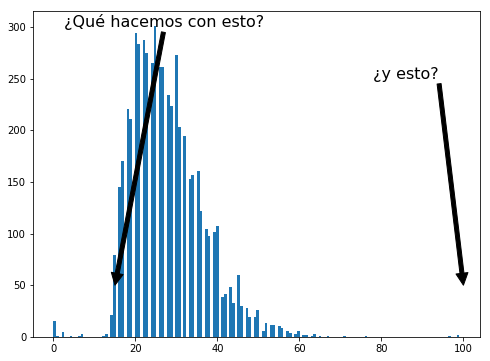

In [26]:
plt.figure(figsize=(8, 6))
plt.hist(dataset.edad, bins=150);
plt.annotate('¿Qué hacemos con esto?', xy=(15, 50), xytext=(2.5, 300),arrowprops=dict(facecolor='black', shrink=15), fontsize=16)
plt.annotate('¿y esto?', xy=(100, 50), xytext=(78, 250), arrowprops=dict(facecolor='black', shrink=15), fontsize=16);
plt.show()

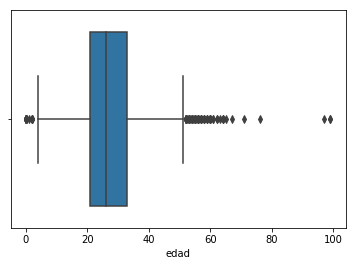

In [27]:
sns.boxplot(dataset.edad)

##### Quitamos los outliers

Vemos como quedaria la distribucion si usamos los rangos intercuartiles para quitar outliers

In [28]:
dataset_edad = dataset["edad"]

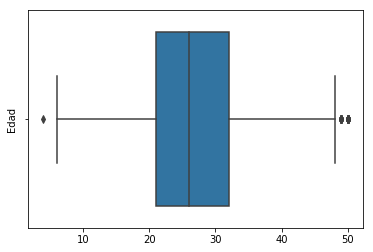

In [29]:
q1 = dataset_edad.quantile(0.25)
q2 = dataset_edad.quantile(0.5)
q3 = dataset_edad.quantile(0.75)

iqr = q3 - q1

up_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5* iqr

no_outliers_mask = (dataset_edad > low_threshold) & (dataset_edad < up_threshold)

ax = sns.boxplot(dataset_edad[no_outliers_mask], orient = 'h').set(
    xlabel='', 
    ylabel='Edad'
)

In [30]:
print(f"El skew es {dataset_edad[no_outliers_mask].skew()} cuando quitamos los outliers")

El skew es 0.5893768101027447 cuando quitamos los outliers


In [31]:
dataset_edad[no_outliers_mask].describe()

count    5561.000000
mean       27.400108
std         7.758342
min         4.000000
25%        21.000000
50%        26.000000
75%        32.000000
max        50.000000
Name: edad, dtype: float64

In [32]:
n_without_outliers = dataset_edad[no_outliers_mask].shape[0]
n_including_outliers = dataset_edad.shape[0]

taken_percentage = 100 * n_without_outliers / n_including_outliers
print(f"""
Sin outliers hemos tomado un {taken_percentage:.2f}% de los datos que teníamos, considerando solamente {n_including_outliers - n_without_outliers} registros como outliers
""")


Sin outliers hemos tomado un 97.97% de los datos que teníamos, considerando solamente 115 registros como outliers



#### Género de encuestados

In [33]:
dataset["genero"].value_counts()

Mujer     4736
Hombre     912
Otro        28
Name: genero, dtype: int64

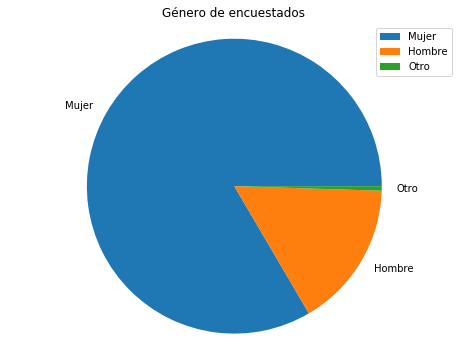

In [34]:
labels = dataset.genero.value_counts(normalize=True).index
sizes = list(dataset.genero.value_counts(normalize=True))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, labels=labels)
ax1.axis('equal') 
ax1.set_title('Género de encuestados')
ax1.legend()

#### Respuestas según género

In [35]:
preguntas = ['1. ¿Cuando no están juntos/as, ¿tu pareja te controla preguntándote con quién estás,\n dónde y qué estás haciendo mensajeándote por celular?', 
 '2. ¿Revisa los mensajes de tu celular o te pidió la contraseña de tu correo electrónico,\n Facebook o Instagram como “prueba de confianza”?',
 '3. ¿Te acusa de haber sido infiel o coquetear con otras/os?',
 '4. ¿Sentís que están permanentemente en tensión y que, hagas lo que hagas, se irrita\n o te culpabiliza de sus cambios de humor?',
 '5. ¿Le molesta que hagas actividades de manera independiente, como estudiar, trabajar,\n visitar amigos/as, ir al gimnasio o elegir quedarte solo/a en tu casa?',
 '6. ¿Sentís que te alejaste o perdiste contacto con amigos/as o familiares desde que estás en pareja?',
 '7. ¿Te dice cómo tenés que vestirte o cómo debe ser tu apariencia?',
 '8. ¿Menosprecia en público o en privado tus opiniones?',
 '9. ¿Te dice que todo lo que hacés está mal o que no servís para nada?',
 '10. ¿Te amenaza con lastimarse/te si no lo/la obedecés o si querés terminar la relación?',
 '11. Después de un episodio violento, ¿se muestra cariñoso/a o atento/a\n y promete que nunca más lo hará y todo cambiará?',
 '12. ¿Indaga o cuestiona tus noviazgos anteriores?',
 '13. ¿Te sentís presionado/a a realizar determinadas prácticas sexuales por temor a que te deje?']

In [36]:
respuestas = ['A = Siempre', 'B = "A veces"', 'C = Nunca']

In [37]:
data = dataset[['genero'] + list(dataset.columns[6:18])]

In [38]:
for columna in data.drop('genero',axis=1).columns:
    data.loc[:,columna] = dataset.loc[:,columna].replace('A','Siempre').replace('B','A veces').replace('C','Nunca')

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Ploteamos las respuestas, relativas al género de los encuestados

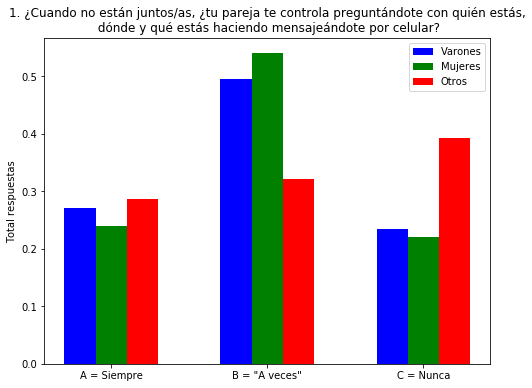

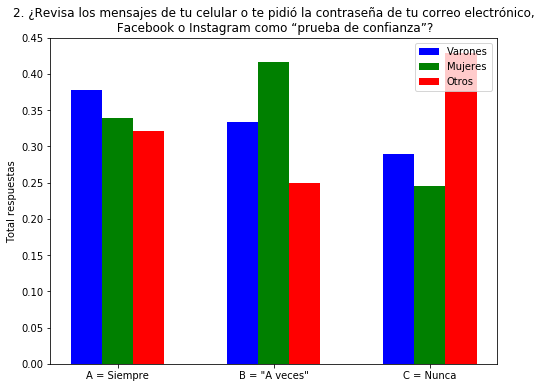

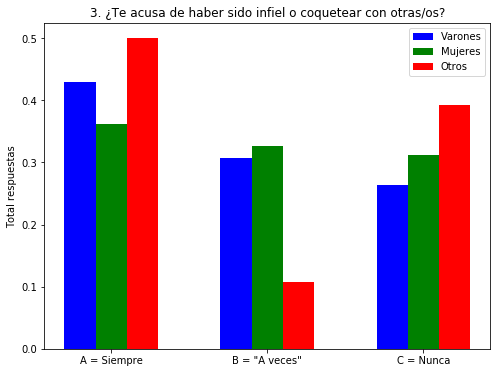

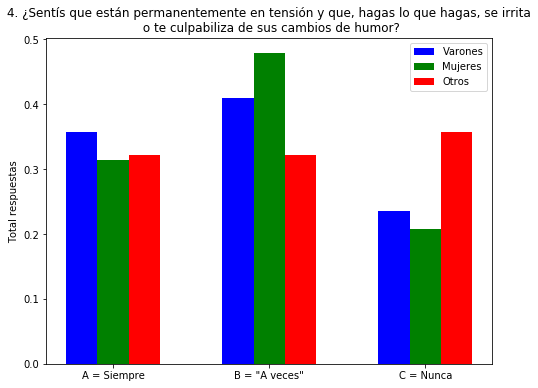

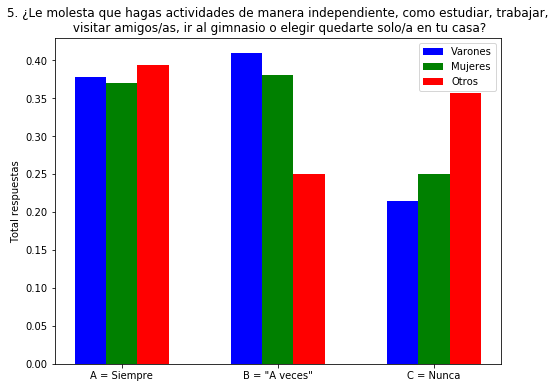

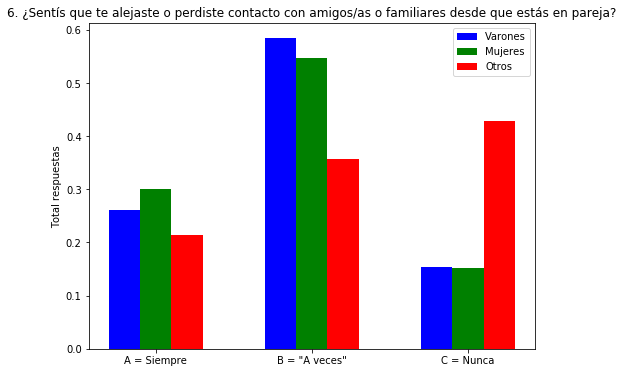

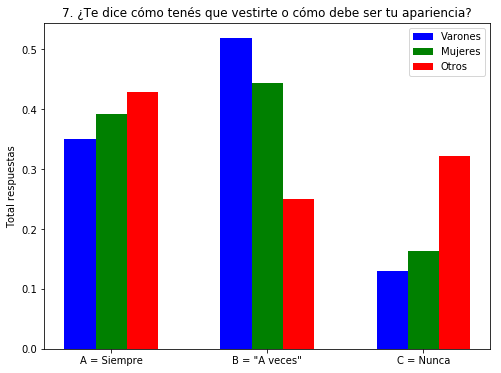

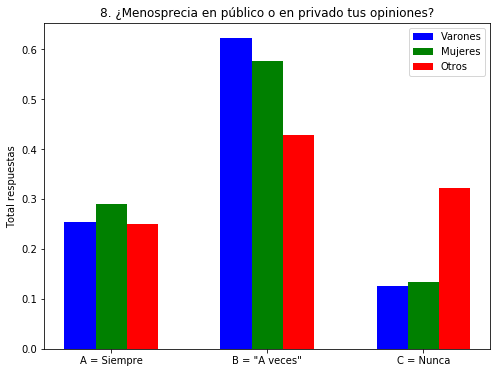

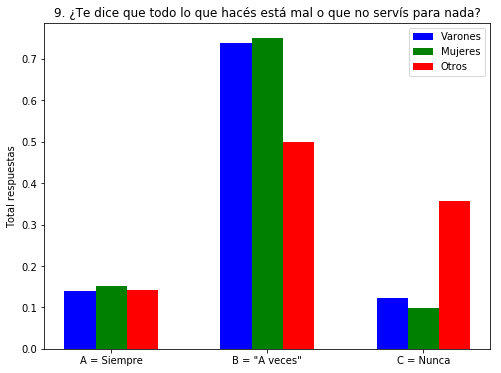

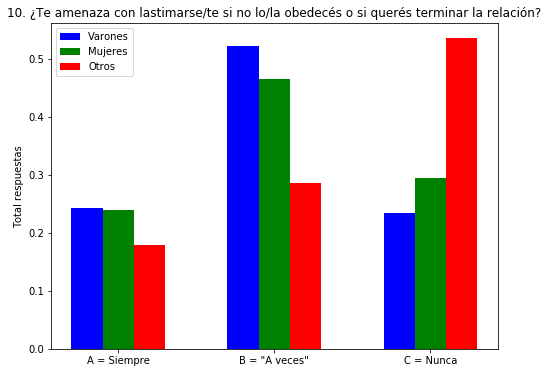

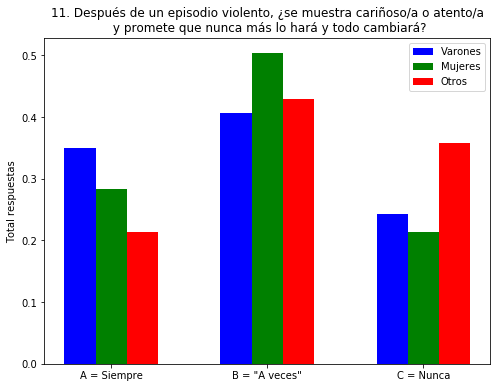

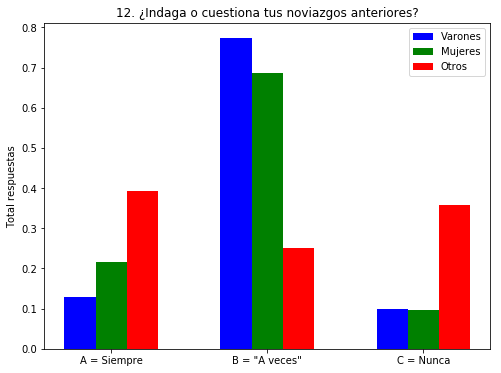

In [39]:
for num,columna in enumerate(data.drop('genero',axis=1).columns):
    respuesta = set(np.array(list(data.groupby(columna).genero.value_counts().index))[:,0])
    # respuesta por hombres
    n_varones = (data.genero == 'Hombre').sum()
    n_mujeres = (data.genero == 'Mujer').sum()
    n_otros = (data.genero == 'Otro').sum()
    varones = list(data.groupby(columna).genero.value_counts())[1::3] / n_varones
    # respusta por mujeres
    mujeres = list(data.groupby(columna).genero.value_counts())[::3] / n_mujeres 
    # respusta por otros
    otros = list(data.groupby(columna).genero.value_counts())[2::3] / n_otros

    x = np.arange(len(respuesta))
    width = 0.2

    fig, ax = plt.subplots(figsize=(8,6))
    barra1 = ax.bar(x, varones, width, label='Varones', color='blue')
    barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres', color='green')
    barra3 = ax.bar(x+0.4, otros, width, label='Otros', color='red')

    ax.set_ylabel('Total respuestas')
    ax.set_title(preguntas[num])
    ax.set_xticks(x+0.2)
    ax.set_xticklabels(respuestas)
    ax.legend()

### <a id="section_split">1.3 Selección de Target</a> 

Seleccionamos el target ('df.pregunta_13') y lo transformamos en dicotómico

In [40]:
# agrego el target al dataframe
dataset['target'] = dataset.pregunta_13 != 'C'

In [41]:
# agrego el target al dataframe al dataframe destinado al ploteo para ver distribución de las respuestas
data['target']  = dataset.target.apply(lambda x: 'Nunca' if x is False else 'Siempre')

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
data.target.value_counts()

Nunca      3963
Siempre    1713
Name: target, dtype: int64

Observamos la distribución de las respuestas del target

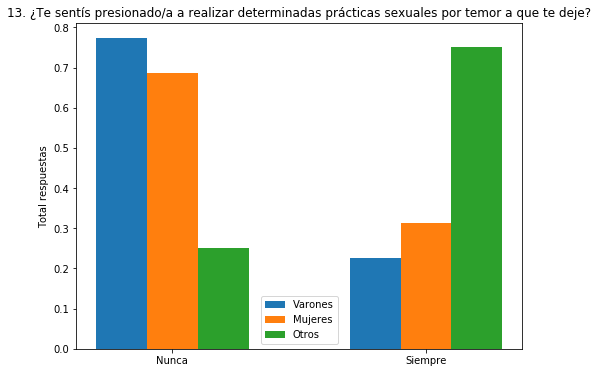

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

respuesta = list(data.target.value_counts().index)

n_varones = (data.genero == 'Hombre').sum()
n_mujeres = (data.genero == 'Mujer').sum()
n_otros = (data.genero == 'Otro').sum()

varones = list(data.groupby('target').genero.value_counts())[1::3] / n_varones
mujeres = list(data.groupby('target').genero.value_counts())[::3] / n_mujeres 
otros = list(data.groupby('target').genero.value_counts())[2::3] / n_otros

x = np.arange(len(respuesta))
width = 0.2

barra1 = ax.bar(x, varones, width, label='Varones')
barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres')
barra3 = ax.bar(x+0.4, otros, width, label='Otros')

ax.set_ylabel('Total respuestas')
ax.set_title(preguntas[12])
ax.set_xticks(x + 0.2)
ax.set_xticklabels(respuesta)
ax.legend()

Observamos que los casos negativos son mayoría, salvo entre quienes declararon "otros" en la pregunta sobre el género

<hr>

## <a id='section_algoritmos'>2. Algoritmos y predicción</a>

### <a id='acon_dataset'>2.1 Acondicionamiento del Dataset</a>

#### Distinción de variables categoricas y continuas

In [44]:
categorical_columns = ['genero', 'barrio_completo'] + [col for col in dataset.columns if 'pregunta_13' not in col and 'pregunta' in col]

In [45]:
numerical_columns = ['edad', 'poblacion_por_barrio']

#### Creacion de dummies

In [46]:
categorical_features_df = pd.get_dummies(dataset.loc[:, categorical_columns])

In [47]:
# agregamos los dummmies al datset

dataset = pd.concat([dataset, categorical_features_df], axis = 1)

In [48]:
# lista de varibales categóricas
categorical_features = categorical_features_df.columns.tolist()

#### train y test: divido utilizando los indices solamente

In [49]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(dataset.index, stratify = dataset.target, random_state = 42)

#### Escalado de variables continuas

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# entreno el modelo de estandarización
scaler.fit(dataset.loc[train_index, numerical_columns])

# transformo cada set de datos de las columnas con variables numéricas
train_numerical_scaled = scaler.transform(dataset.loc[train_index, numerical_columns])
test_numerical_scaled = scaler.transform(dataset.loc[test_index, numerical_columns])

In [51]:
# lista de variables numéricas
numerical_features = [f"{col}_scaled" for col in numerical_columns]

In [52]:
train_numerical_df = pd.DataFrame(train_numerical_scaled, index = train_index, columns = numerical_features)
test_numerical_df = pd.DataFrame(test_numerical_scaled, index = test_index, columns = numerical_features)

numerical_features_df = train_numerical_df.append(test_numerical_df)

#### Agrego features numéricas escaladas al dataset

In [53]:
dataset = pd.concat([dataset, numerical_features_df], axis = 1)

#### Generacion de train/test datasets con los features transformados y estandarizados

In [54]:
# los features equivalen a las variables categóricas dummies y a las numéricas estandarizadas
feature_cols = categorical_features + numerical_features

In [55]:
dataset_to_use = dataset.loc[:, feature_cols + ['target']]

In [56]:
train = dataset_to_use.loc[train_index]
test = dataset_to_use.loc[test_index]

In [57]:
X_train = train.drop('target', axis=1)
y_train = train.target

In [58]:
X_test = test.drop('target', axis=1)
y_test = test.target

#### Guardo train y test en formato csv para compartir

In [59]:
train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

### <a id='knn'>2.1 K Nearest Neighbors (KNN)</a>

#### Ajustando el modelo
Buscando el mejor hiperparámetro

In [60]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)

In [62]:
scores = []

for i in range(1,10):
    modelo =  KNeighborsClassifier(n_neighbors=i)
    cvs = cross_val_score(modelo, X_train, y_train ,cv=kf)
    scores.append({'vecinos':i,
                  'media':np.mean(cvs),
                  'desvio':np.std(cvs)})

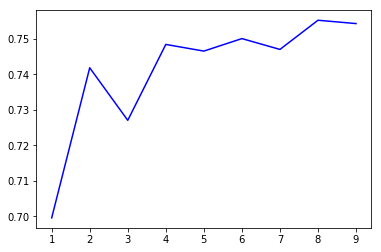

In [63]:
scores = pd.DataFrame(scores)
plt.plot(range(1,10), scores.media, color='b')

#### Hiperparámetro óptimo

In [64]:
scores.loc[scores.media == scores.media.max(),:]

,vecinos,media,desvio
7,8,0.75523,0.013181


In [65]:
vecinos = int(scores.loc[scores.media == scores.media.max(),'vecinos'])

#### Entreno el modelo

In [66]:
knn = KNeighborsClassifier(n_neighbors=vecinos)

In [67]:
knn.fit(X_train, y_train);

#### Prediciendo sobre test

In [68]:
y_pred_knn = knn.predict(X_test)

In [69]:
(y_test == y_pred_knn).sum() / y_test.shape[0]

0.755461592670895

#### Evaluando resultados

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report

In [71]:
confusion_knn = confusion_matrix(y_test, y_pred_knn)

In [72]:
TP_knn = confusion_knn[0,0]
TN_knn = confusion_knn[1,1]
FP_knn = confusion_knn[0,1]
FN_knn = confusion_knn[1,0]
TP_knn, TN_knn, FP_knn, FN_knn

(906, 166, 85, 262)

#### Accuracy KNN - Test
Predicciones verdades sobre total de predicciones

In [73]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_knn, (TP_knn + TN_knn) / (TP_knn + TN_knn + FP_knn + FN_knn)

(0.755461592670895, 0.755461592670895)

[Text(0,0.5,'Nunca'), Text(0,1.5,'Siempre')]

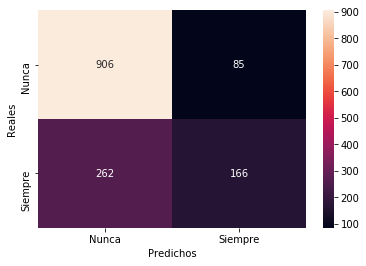

In [74]:
fig = plt.figure()
ax = plt.axes()
sns.heatmap(confusion_knn,annot=True, fmt='.0f')
plt.xlabel('Predichos')
plt.ylabel('Reales')
ax.set_xticklabels(['Nunca','Siempre'])
ax.set_yticklabels(['Nunca','Siempre'])

#### Precision KNN - Test
¿con qué rigurosidad etiqueta como no positiva ('siempre') una respuesta que es negativa ('nunca')?

In [75]:
precision_score(y_test, y_pred_knn)

0.6613545816733067

#### Sensitivity o recall_score - Test
De las respuestas positivas, ¿cuántas son verdaderametne positivas?

In [76]:
recall_knn = recall_score(y_test, y_pred_knn)
recall_knn

0.3878504672897196

### <a id='#reg_log'>2.2 Regresión Logística</a>

In [77]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [78]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

y_pred_log_train = lr.predict(X_train_std)

#### Accuracy - Log. Regression - Train

In [79]:
# accuracy sobre train

accuracy_log_train = accuracy_score(y_train, y_pred_log_train)
accuracy_log_train

0.7747239840263096

[Text(0,0.5,'Nunca'), Text(0,1.5,'Siempre')]

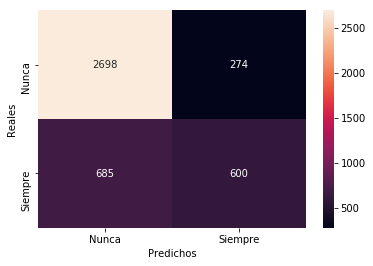

In [80]:
# heatmap sobre train

fig = plt.figure()
ax = plt.axes()
sns.heatmap(confusion_matrix(y_train, y_pred_log_train), annot=True, fmt='.0f')
plt.xlabel('Predichos')
plt.ylabel('Reales')
ax.set_xticklabels(['Nunca','Siempre'])
ax.set_yticklabels(['Nunca','Siempre'])

#### Histograma de probabilidades

In [81]:
nunca = lr.predict_proba(X_train_std[y_train==0])[:,1]
siempre = lr.predict_proba(X_train_std[y_train==1])[:,1]
nunca.shape, siempre.shape

((2972,), (1285,))

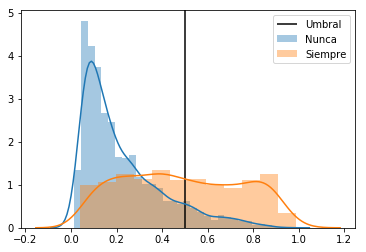

In [82]:
sns.distplot(nunca)
sns.distplot(siempre)
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])

#### Corremos el umbral a 0.3<br>
Creemos que es preferible contemplar todos los casos predichos como violentos, a descartar aquellos que siendolos corran el riesgo de ser pasados por alto por el modelo 

In [83]:
umbral = 0.3

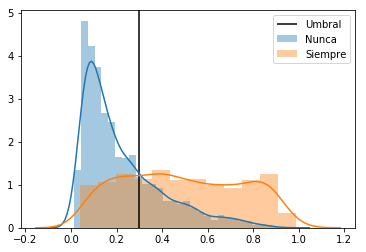

In [84]:
sns.distplot(nunca)
sns.distplot(siempre)
ylim = plt.ylim()
plt.vlines(umbral, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])

In [85]:
print('Respuestas "Siempre" con umbral por defecto:', (lr.predict_proba(X_train_std)[:,1] > 0.5).sum())
print('Respuestas "Siempre" con umbral 0.3:', (lr.predict_proba(X_train_std)[:,1] > 0.5).sum(), (lr.predict_proba(X_train_std)[:,1] > 0.3).sum())

Respuestas "Siempre" con umbral por defecto: 874
Respuestas "Siempre" con umbral 0.3: 874 1671


In [86]:
y_pred_log_ajustado = lr.predict_proba(X_train_std)[:,1] > umbral

#### Matriz de confusión con umbral 0.3<br>
Evaluamos la matriz con el nuevo umbral

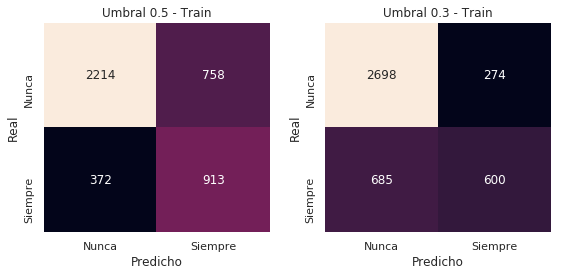

In [107]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_train, y_pred_log_train), cbar=False, annot=True, fmt='.0f',ax=axes[1])
sns.heatmap(confusion_matrix(y_train, y_pred_log_ajustado), cbar=False, annot=True, fmt='.0f',ax=axes[0])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('Umbral 0.5 - Train')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('Umbral 0.3 - Train')

plt.tight_layout()

Como se percibe, aumentan las predicciones de respuestas "siempre" para todos los casos, mientras que disminuye la predicción de la respuesta "nunca"

#### Predicción sobre Test - Log. Regression

In [88]:
from sklearn.metrics import f1_score

y_pred_log = lr.predict(X_test)
print(f1_score(y_test,y_pred_log))

0.08071748878923767


In [89]:
y_pred_proba_log = lr.predict_proba(X_test)

In [92]:
all(pd.Series(y_pred_proba_log[:,1]>0.5).astype(int)==pd.Series(y_pred_log))

True

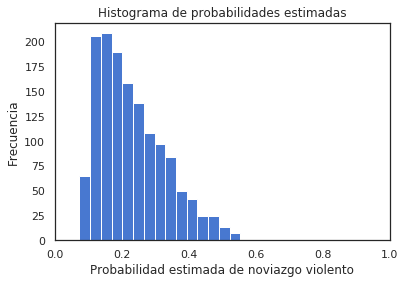

In [93]:
# Nos quedamos con la columna que tiene la probabilidad positiva ('siempre') de cada caso
y_probs_logit_left = y_pred_proba_log[:,1]

# Generamos un histograma de esa columna
plt.hist(y_probs_logit_left, bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad estimada de noviazgo violento')
plt.ylabel('Frecuencia')
plt.show()

In [94]:
from sklearn.preprocessing import binarize

# modificamos el umbral para rehacer la predicción sobre test
y_pred_logit_log = (binarize(y_pred_proba_log, 0.3)[:,1]).astype(int)

In [95]:
y_pred_logit_log.sum()

339

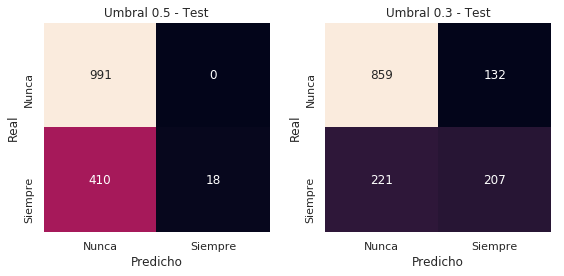

In [105]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_test,y_pred_log), cbar=False, annot=True, fmt='.0f',ax=axes[0])
sns.heatmap(confusion_matrix(y_test,y_pred_logit_log), cbar=False, annot=True, fmt='.0f',ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('Umbral 0.5 - Test')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('Umbral 0.3 - Test')

plt.tight_layout()

#### Specifity - Log. Regression

In [108]:
def specificy(test, pred):
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    specificity = tn / (tn+fp)
    return(specificity)

print('Umbral 0.5 =', specificy(y_test, y_pred_log))
print('Umbral 0.3 =', specificy(y_test, y_pred_logit_log))

Umbral 0.5 = 1.0
Umbral 0.3 = 0.8668012108980827


#### Accuracy - Log. Regression

In [109]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_log_umbral = accuracy_score(y_test, y_pred_logit_log)

print('Umbral 0.5 =', accuracy_log)
print('Umbral 0.3 =', accuracy_log_umbral)

Umbral 0.5 = 0.7110641296687809
Umbral 0.3 = 0.7512332628611699


#### Sensibility / recall - Log. Regression

In [110]:
recall_log = recall_score(y_test, y_pred_log)
recall_log_umbral = recall_score(y_test, y_pred_logit_log)

print('Umbral 0.5 =', recall_log)
print('Umbral 0.3 =', recall_log_umbral)

Umbral 0.5 = 0.04205607476635514
Umbral 0.3 = 0.48364485981308414


#### Curva ROC y AUC

In [ ]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba_log[:,1])

In [ ]:
df_roc = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df_roc['fpr'],df_roc['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [ ]:
from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

### <a id='naive'>2.3 Naive Bayes Gaussian</a>

In [112]:
from sklearn.naive_bayes import GaussianNB

In [113]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Verifico performance de NaiveBayes

In [114]:
y_pred_gnb = gnb.predict(X_test)
y_pred_proba_gnb = gnb.predict_proba(X_test)

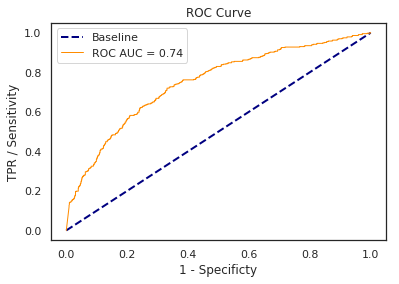

In [115]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gnb[:,1])
auc_score = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw = 2)
plt.plot(fpr, tpr, color = 'darkorange', lw = 1)
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.legend(['Baseline', f'ROC AUC = {auc_score:.2f}'])

In [116]:
print(f'Naive Bayes F1 Score = {f1_score(y_test, y_pred_gnb):.2f}')

Naive Bayes F1 Score = 0.57


In [117]:
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f'Naive Bayes Accuracy = {accuracy_gnb:.2f}')

Naive Bayes Accuracy = 0.71


In [118]:
recall_gnb = recall_score(y_test, y_pred_gnb)
print(f'Naive Bayes Recall = {recall_gnb:.2f}')

Naive Bayes Recall = 0.63


[Text(0,0.5,'Nunca'), Text(0,1.5,'Siempre')]

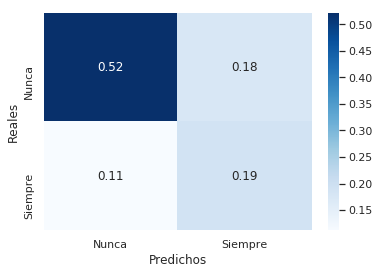

In [120]:
fig = plt.figure()
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test, y_pred_gnb, normalize = 'all'), annot = True, cmap="Blues")
plt.xlabel('Predichos')
plt.ylabel('Reales')
ax.set_xticklabels(['Nunca','Siempre'])
ax.set_yticklabels(['Nunca','Siempre'])

## <a id='resultados'>2.4 Comparación de Resultados</a>

### Naive Bayes (Gaussian) VS Log. Regression

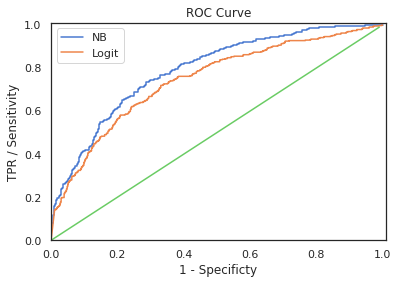

In [121]:
fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_pred_proba_log[:,1])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba_gnb[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','Logit'])
plt.show() 

In [122]:
print('AUC-NB=', auc(fpr_nb, tpr_nb))
print('AUC-Logit=', auc(fpr_log, tpr_log))

AUC-NB= 0.7905943208502693
AUC-Logit= 0.7442119260258212


### Accuracy / Recall - Naive Bayes (Gaussian) VS Log. Regression VS KNN

Text(0.5,1,'Recall - Test')

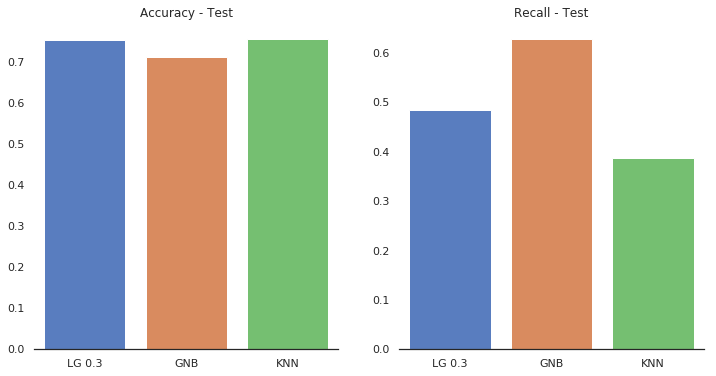

In [135]:
f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex='all')
sns.despine(left=True)

sns.barplot(x=['LG 0.3','GNB','KNN'],y=[accuracy_log_umbral, accuracy_gnb, accuracy_knn],ax=axes[0])
sns.barplot(x=['LG 0.3','GNB','KNN'],y=[recall_log_umbral, recall_gnb, recall_knn],ax=axes[1])
axes[0].set_title('Accuracy - Test')
axes[1].set_title('Recall - Test')

<hr>

## <a id='section_consolidacion'>3. Consolidación</a>

### <a id='pipe'>3.1 Pipelines</a>

In [ ]:
X = df.drop('pregunta_13', axis = 1)
y = (df.pregunta_13 != 'C').astype(int)

In [ ]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


Genero un transformador que toma las columnas que quiero y asi reutilizarlo en varios steps

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features=selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.selected_features]

Para la edad el pipeline va a crear 4 bins:

* Menor de 25
* De 25 a 49
* De 50 a 74
* De 75 en adelante

In [ ]:
edad_pipeline = make_pipeline(ColumnSelector(['edad']), KBinsDiscretizer(4, strategy = 'uniform', encode = 'onehot-dense'))

Para las preguntas, utilizamos OneHotEncoder y utilizamos todas las disponibles en el X

In [ ]:
preguntas_col = [col for col in X.columns if "pregunta_" in col]
preguntas_pipeline = make_pipeline(ColumnSelector(preguntas_col), OneHotEncoder(sparse=False, handle_unknown='ignore'))

Para el barrio y el genero, lo transformamos tambien usando OneHotEncoder

In [ ]:
barrio_pipeline = make_pipeline(ColumnSelector(['barrio']), OneHotEncoder(sparse=False, handle_unknown='ignore'))

In [ ]:
genero_pipeline = make_pipeline(ColumnSelector(['genero']), OneHotEncoder(sparse=False, handle_unknown='ignore'))

Por ultimo, creamos un pipeline con la union de estos pasos anteriores

In [ ]:
preprocess_pipeline = make_union(edad_pipeline, preguntas_pipeline, barrio_pipeline, genero_pipeline)

## Divido en train y test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

## Pipeline de entrenamiento y prediccion

Utilizamos la funcionalidad de GridSearch y Pipelines para probar varios modelos en gridsearch

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

In [ ]:
pipeline = Pipeline(steps = [
    ('preprocess', preprocess_pipeline),
    ('estimator', GaussianNB())
])

Utilizamos el placeholder None para utilizar la grilla de hiperparametros mas adelante para insertarle distintos modelos

## GridSearch 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
params_grid =[
    {'estimator':[GaussianNB()]},
    {
        'estimator': [MultinomialNB()],
        'estimator__alpha': np.linspace(0, 2, 20)
    },
    {
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': range(1, 15),
        'estimator__p': [1, 2]
    },
    {
        'estimator': [LogisticRegression()],
        'estimator__penalty': ['l2', 'l1', 'elasticnet', 'none'],
        'estimator__C': np.linspace(0, 5, 100)
    }
]

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
model = GridSearchCV(pipeline, params_grid, cv = folds, n_jobs = -1, scoring='roc_auc', verbose = 1, return_train_score = True)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.best_score_ 

In [ ]:
model.best_params_ 

## Verificacion de performance

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw = 2)
plt.plot(fpr, tpr, color = 'darkorange', lw = 1)
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.legend(['Baseline', f'ROC AUC = {auc_score:.2f}'])

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize = 'all'), annot = True, cmap="Blues")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

In [ ]:
log_loss(y_test, y_pred_proba)

In [ ]:
log_loss(y_train, model.predict_proba(X_train))